In [2]:
import os
import sys
import json
import torch
import argparse
import numpy as np
import pandas as pd
from torchsummary import summary
import matplotlib.pyplot as plt
from dataloader import data_provider
from stock_picker import StockPicker
from visualize import Visualize, draw_barchart_single
from utills import read_default_args, detect_constant_price
%load_ext autoreload
%autoreload 2

## DLinear

In [3]:
default_args = read_default_args()

In [4]:
# Model specific args
args = {
   'is_training': 1,
   'root_path': '/Users/shiva/Desktop/data_maestro',
   'checkpoints': '/Users/shiva/Desktop/data_maestro/checkpoints/',
   'data_path': 'ltsf.csv',
   'seq_len': 360,
   'pred_len': 90,
   'enc_in': 319,
   'itr': 1,
   'batch_size': 16,
   'learning_rate': 0.05,
   'instrument_file': 'instruments.json',
   'decomp_kernal': 25
}

# Change the default args
for key, value in args.items():
    default_args[key] = value

args = argparse.Namespace(**default_args)
setting = 'sl{}_pl{}_ch{}_ds_{}'.format(args.seq_len, args.pred_len, args.enc_in, args.data_path.split('.')[0])

In [5]:
weights = os.listdir("{}/{}".format(args.checkpoints, setting))
sorted_weights = sorted(weights, key=lambda x: float(x.replace('checkpoint_','').replace('.pth','')), reverse=True)
sorted_weights

['checkpoint_0.2163.pth',
 'checkpoint_0.0589.pth',
 'checkpoint_0.0551.pth',
 'checkpoint_0.0524.pth',
 'checkpoint_0.0503.pth']

In [15]:
vis = Visualize(args, mode='val', setting=setting, weights=sorted_weights[-1], title_meta=1, decision_log=0)

Load model from /Users/shiva/Desktop/data_maestro/checkpoints/sl360_pl90_ch319_ds_ltsf/checkpoint_0.0503.pth
val 1486


In [18]:
stock_picker = StockPicker(args, mode='val', setting=setting, weights=sorted_weights[-1])
best_stocks = stock_picker.pick_stocks(np.arange(0, 319), k=319)

Load model from /Users/shiva/Desktop/data_maestro/checkpoints/sl360_pl90_ch319_ds_ltsf/checkpoint_0.0503.pth
val 1486
(372, 319)


In [13]:
best_stocks[:20]

[143,
 113,
 164,
 173,
 303,
 253,
 3,
 49,
 268,
 310,
 186,
 54,
 26,
 2,
 214,
 305,
 147,
 205,
 83,
 128]

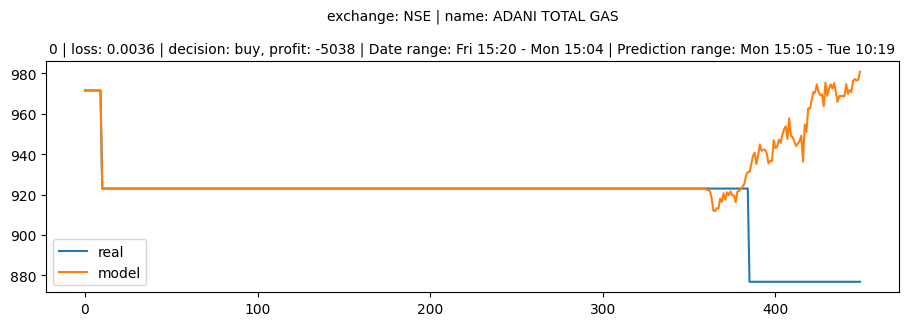

net profit: -5038


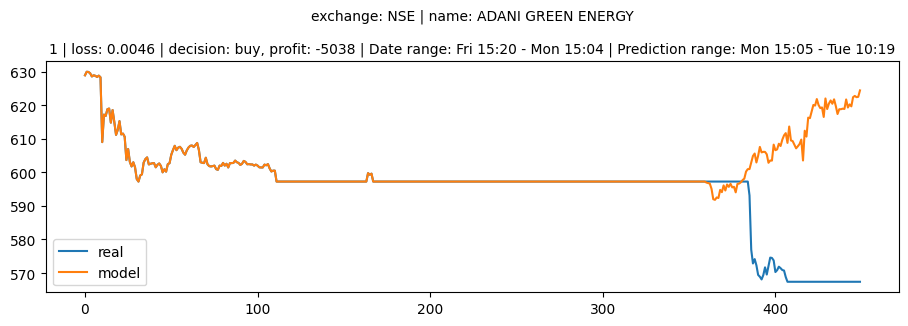

net profit: -10076


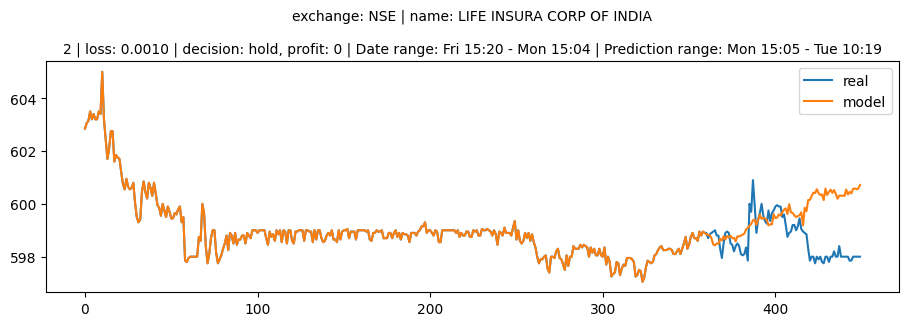

net profit: -10076


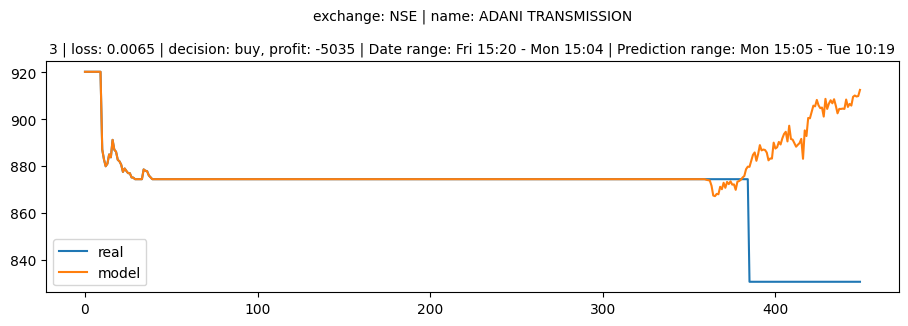

net profit: -15111


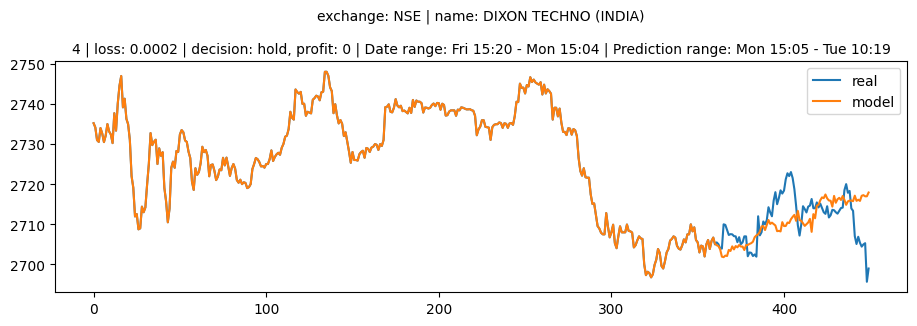

net profit: -15111


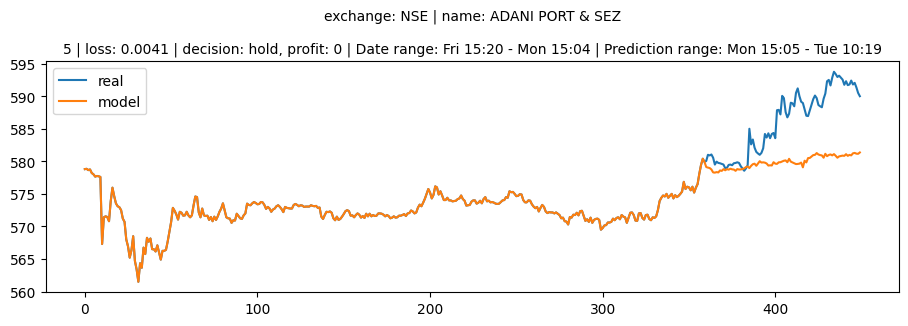

net profit: -15111


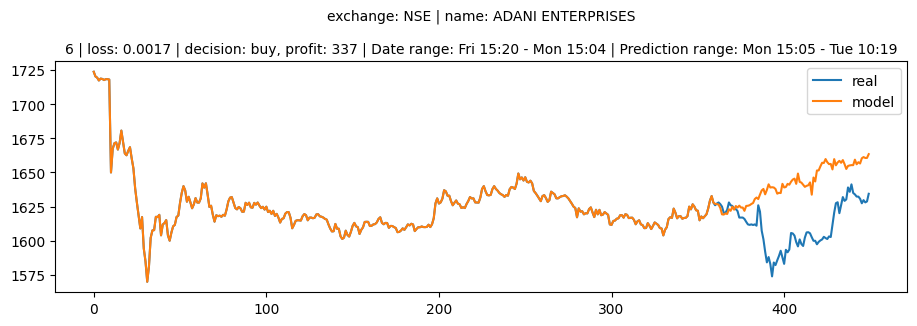

net profit: -14774


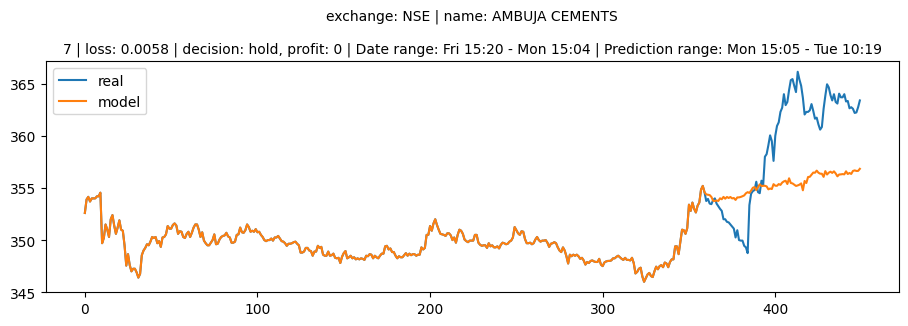

net profit: -14774


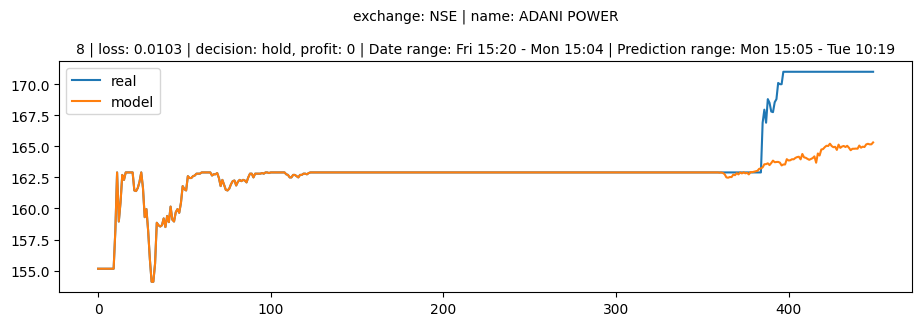

net profit: -14774


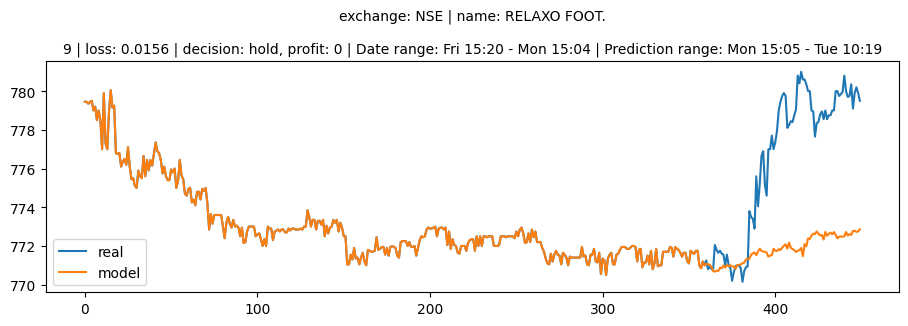

net profit: -14774


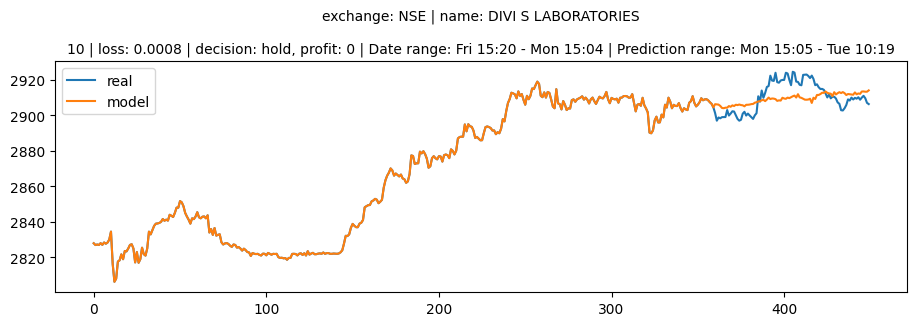

net profit: -14774


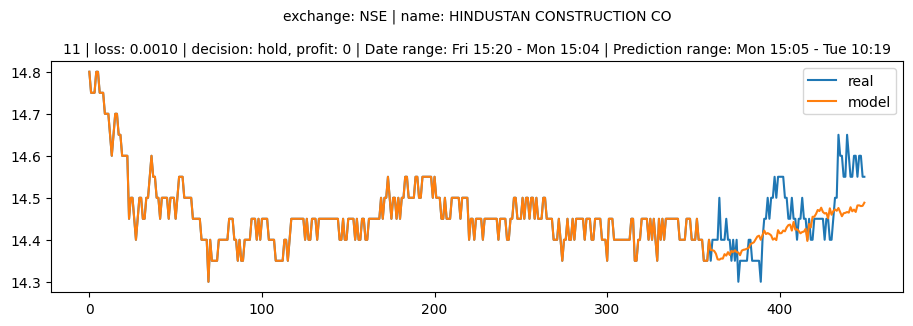

net profit: -14774


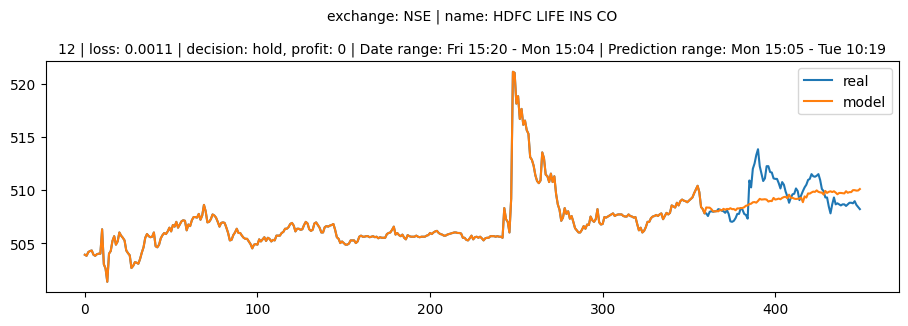

net profit: -14774


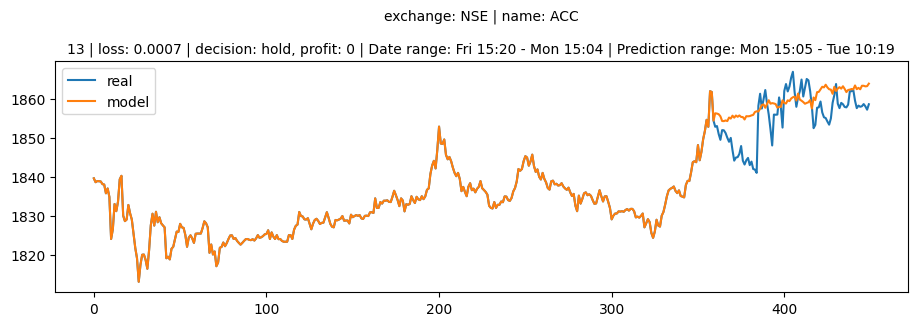

net profit: -14774


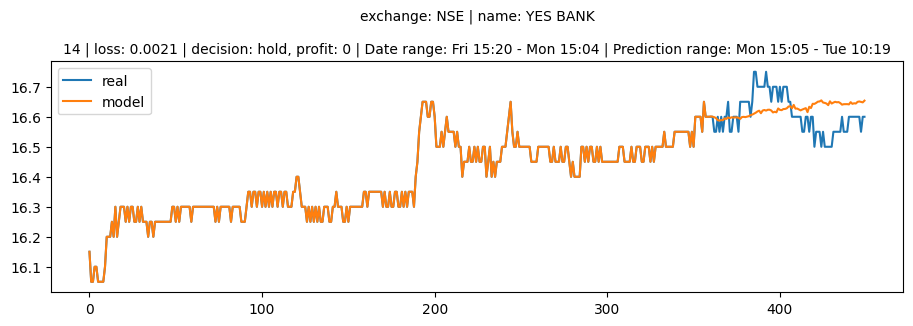

net profit: -14774


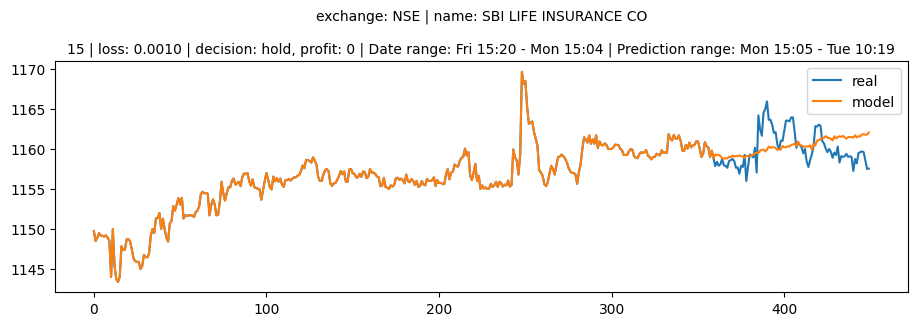

net profit: -14774


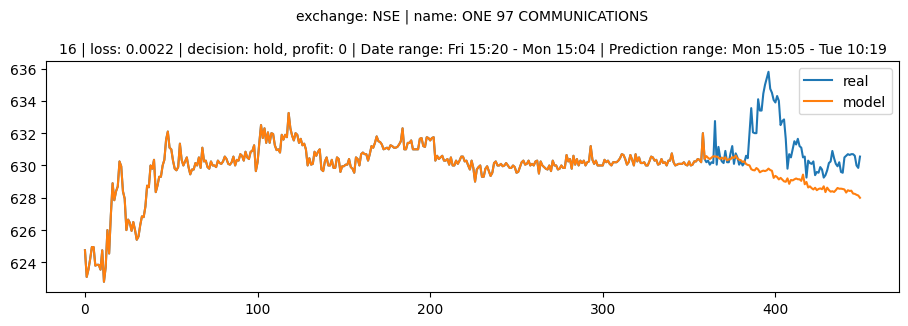

net profit: -14774


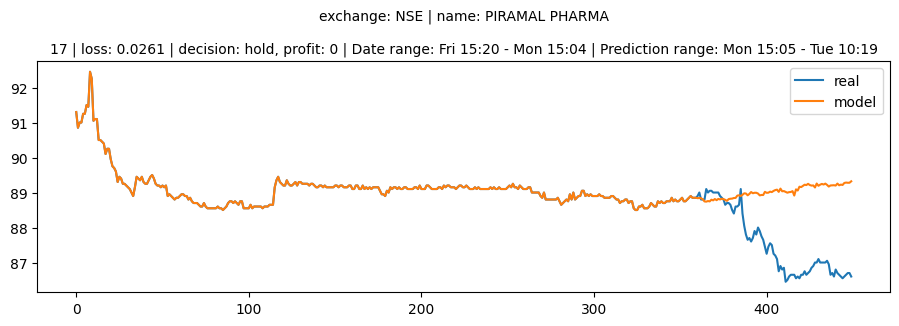

net profit: -14774


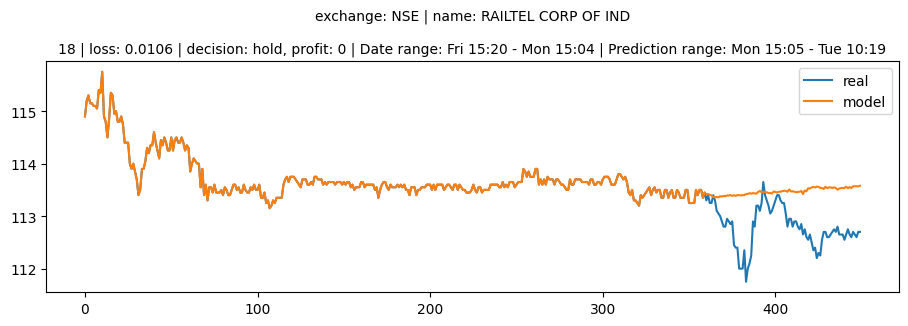

net profit: -14774


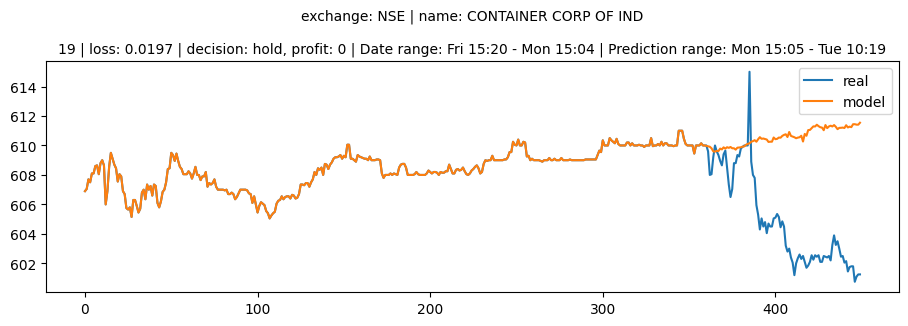

net profit: -14774


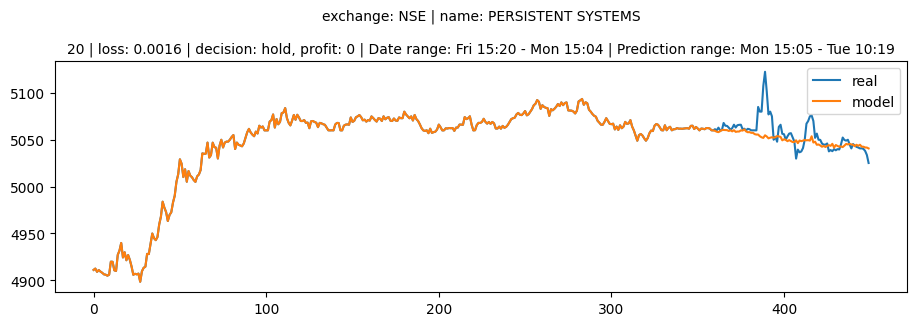

net profit: -14774


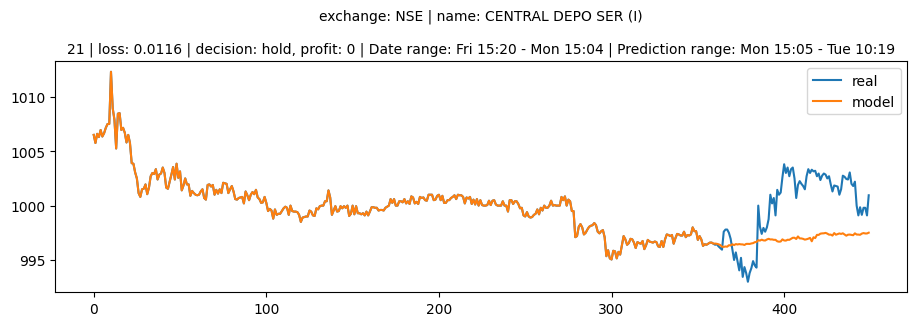

net profit: -14774


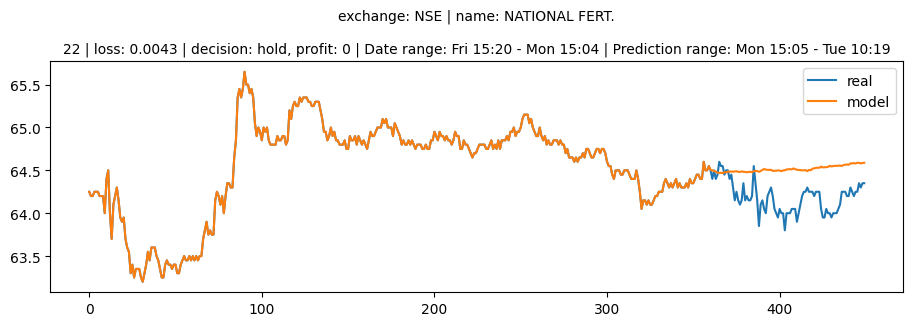

net profit: -14774


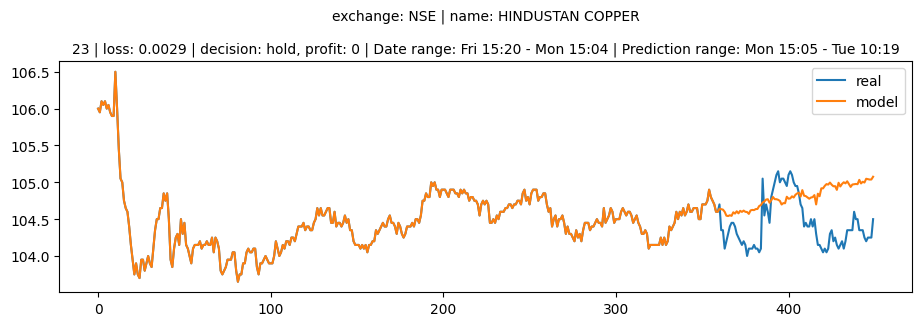

net profit: -14774


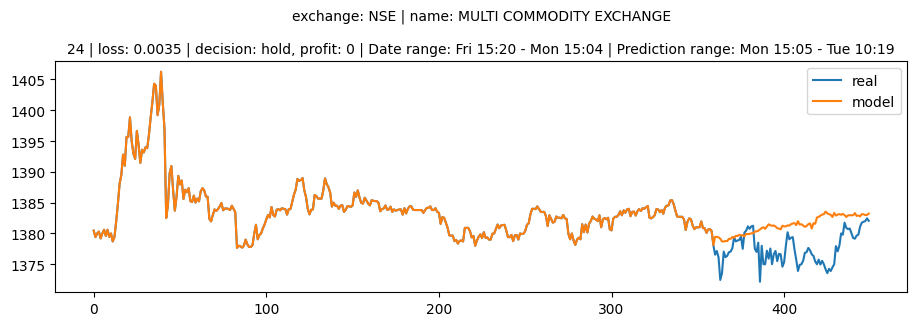

net profit: -14774


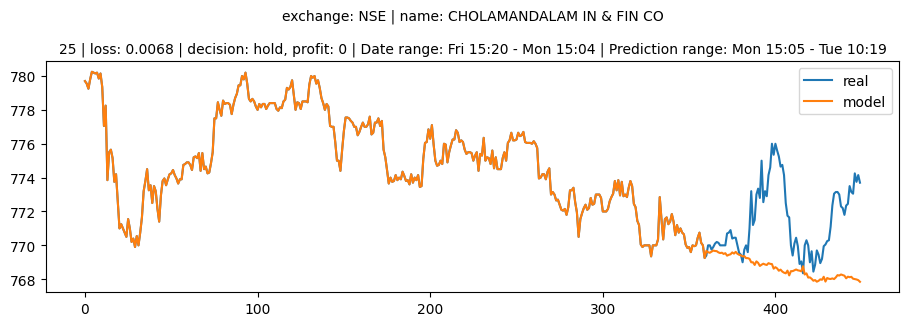

net profit: -14774


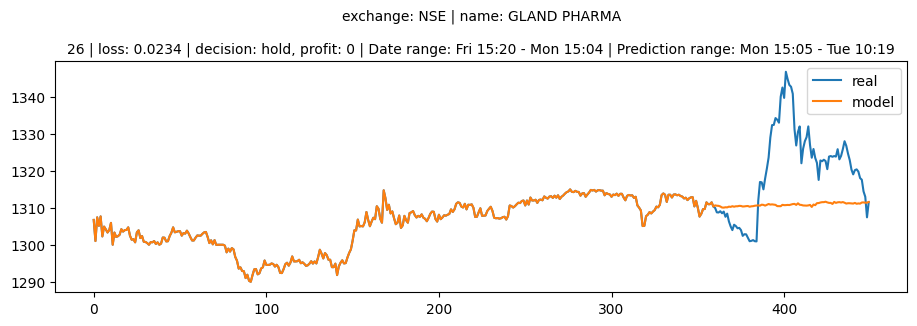

net profit: -14774


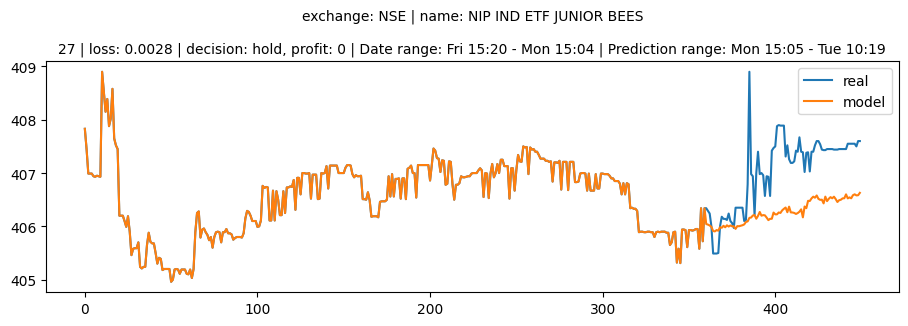

net profit: -14774


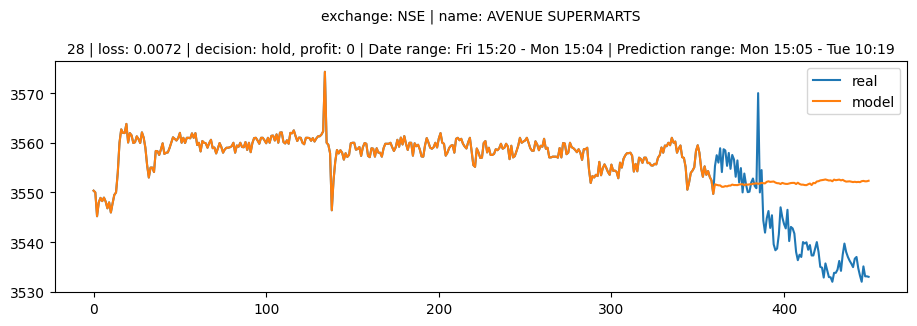

net profit: -14774


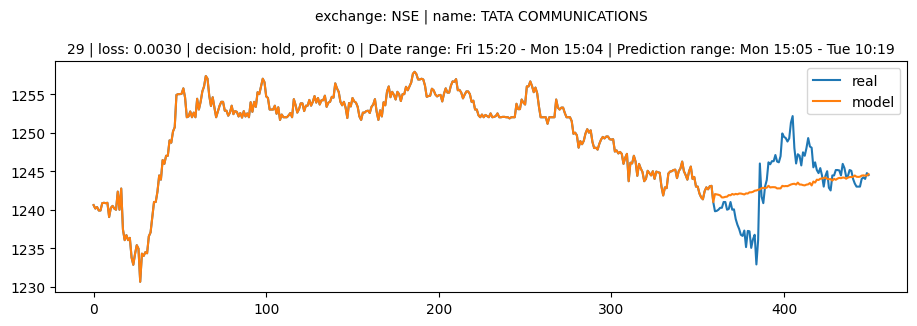

net profit: -14774


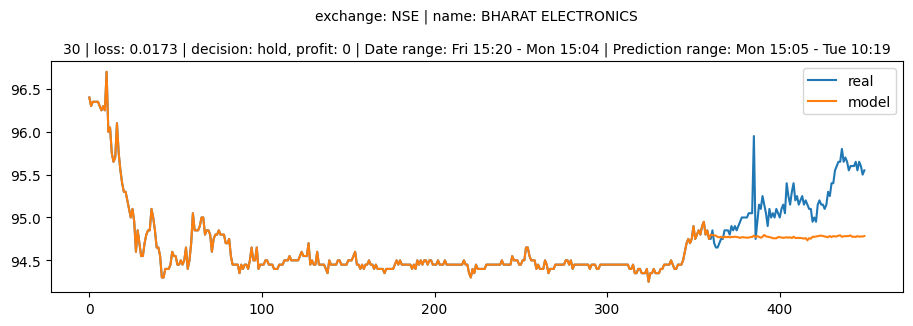

net profit: -14774


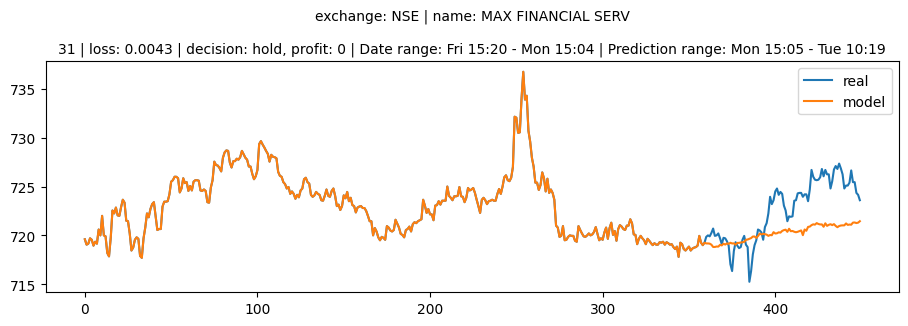

net profit: -14774


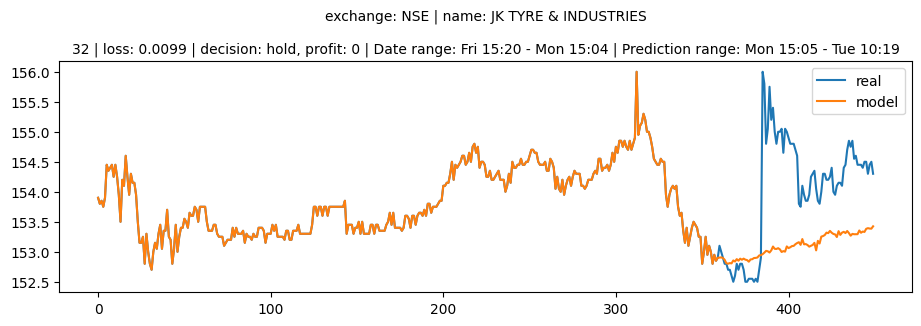

net profit: -14774


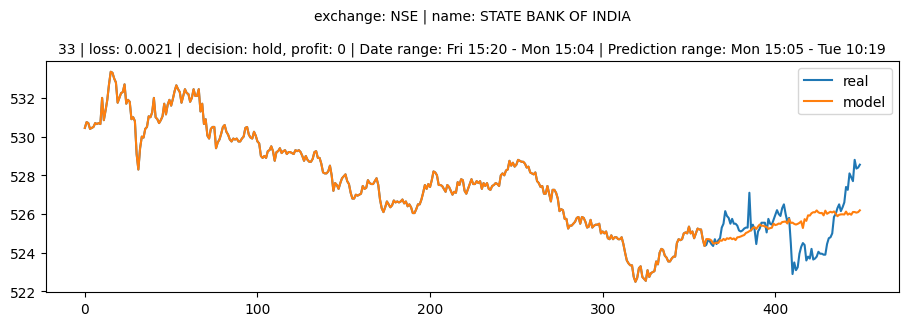

net profit: -14774


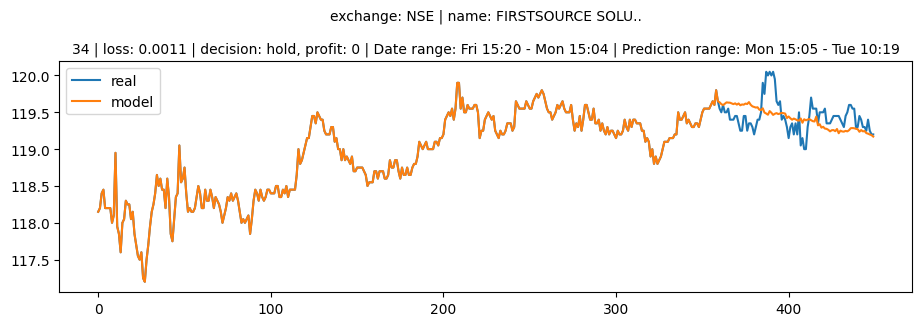

net profit: -14774


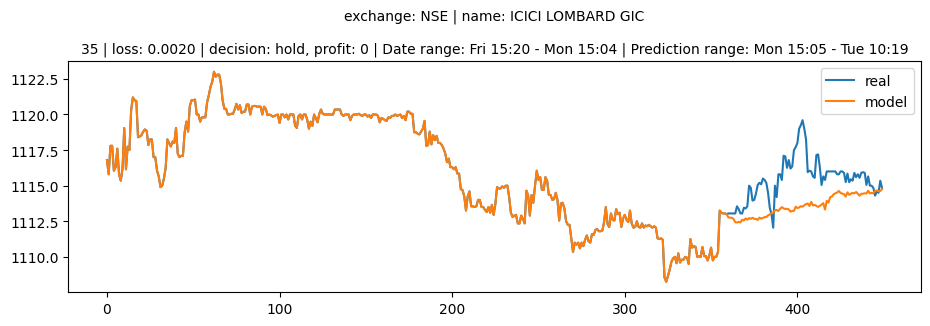

net profit: -14774


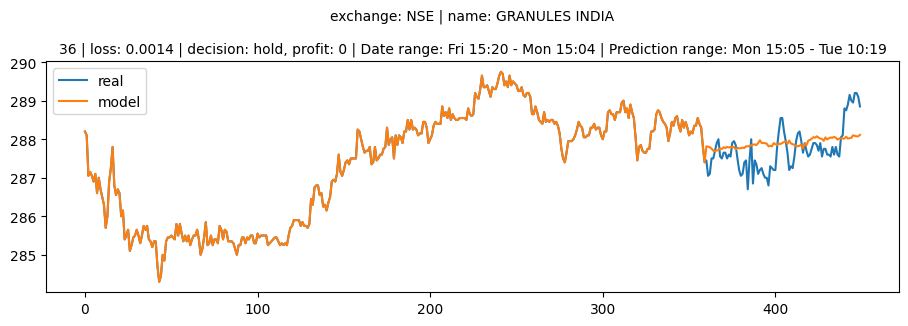

net profit: -14774


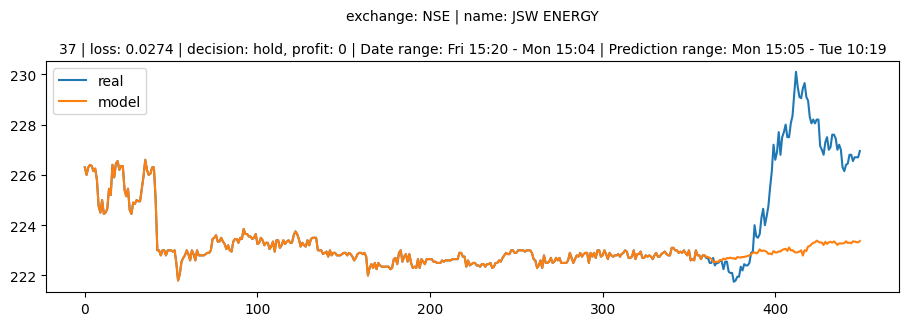

net profit: -14774


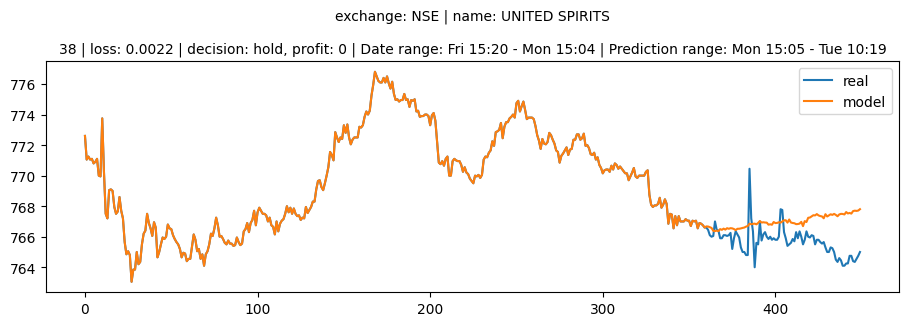

net profit: -14774


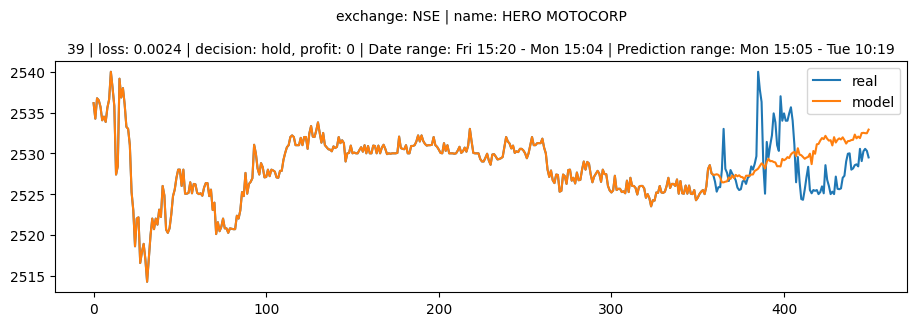

net profit: -14774


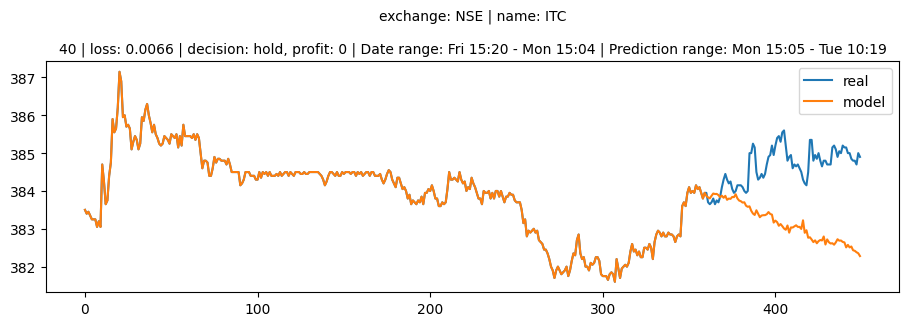

net profit: -14774


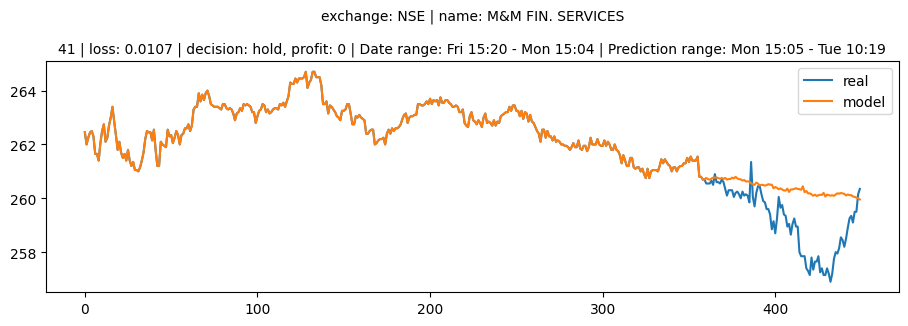

net profit: -14774


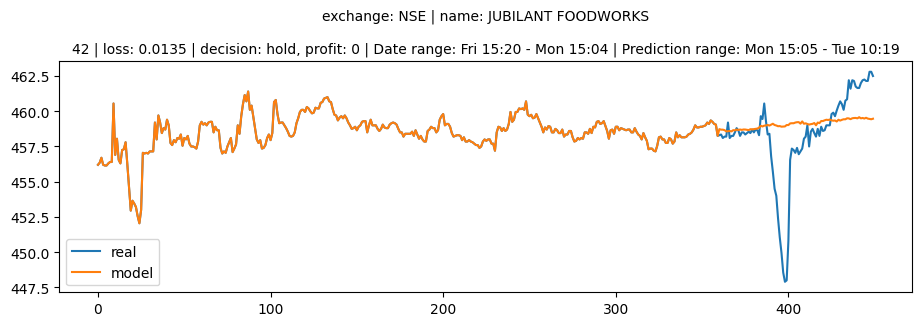

net profit: -14774


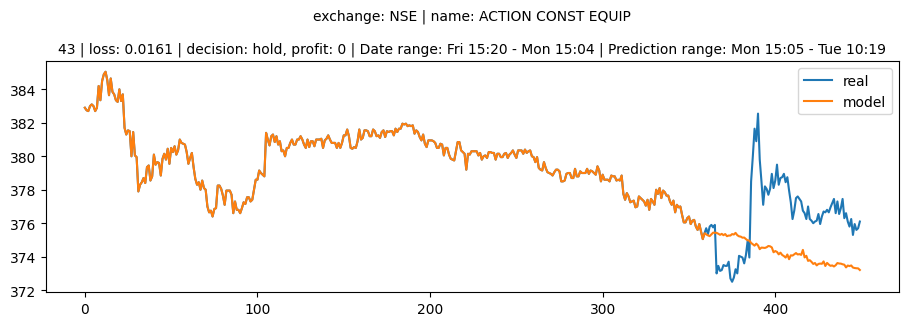

net profit: -14774


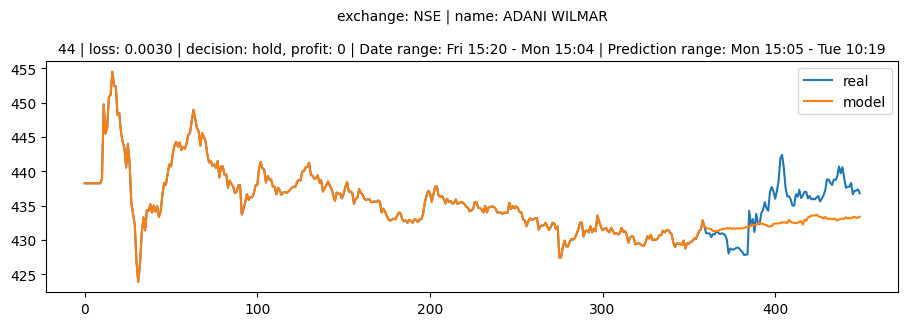

net profit: -14774


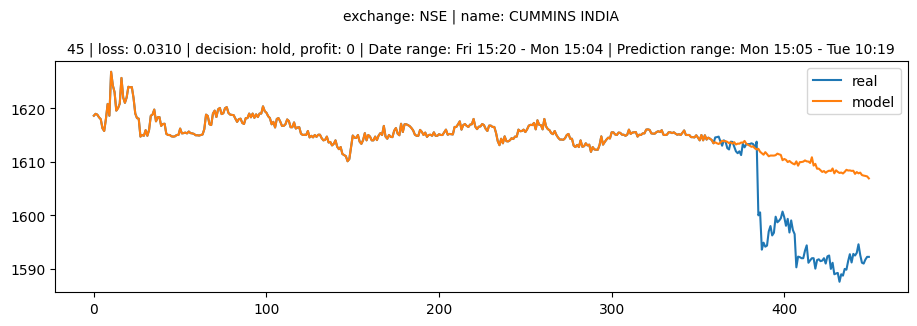

net profit: -14774


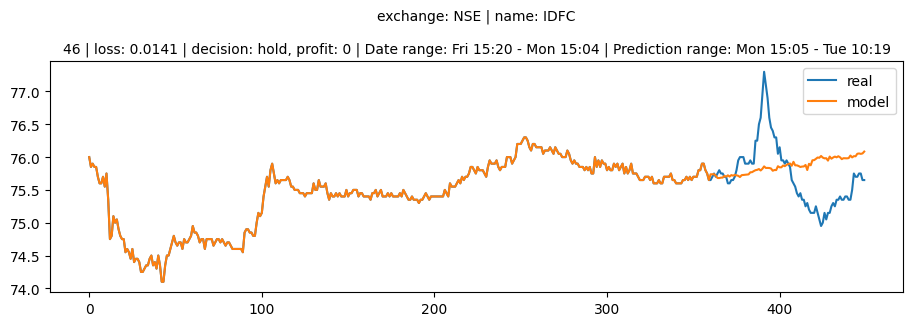

net profit: -14774


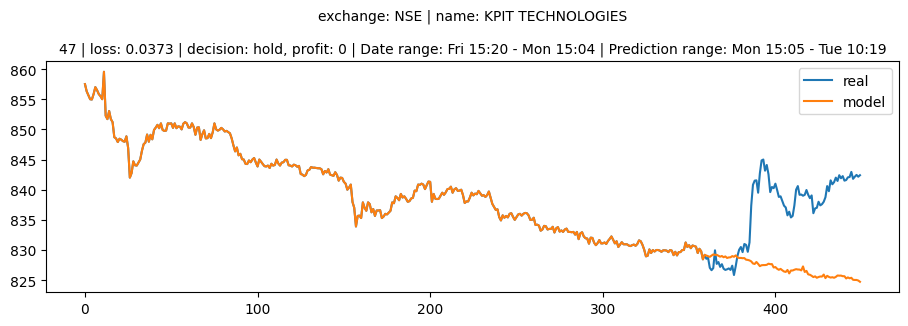

net profit: -14774


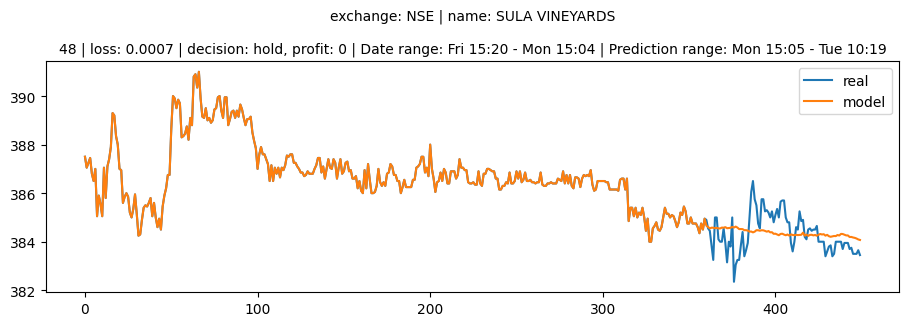

net profit: -14774


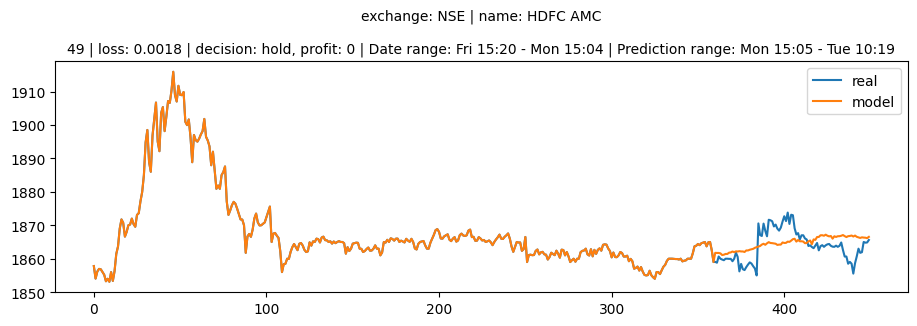

net profit: -14774


(-14774,
 ['Fri 15:20', 'Mon 15:04', 'Mon 15:05', 'Tue 10:19'],
 398408.95,
 4,
 213.34)

In [9]:
vis.plot(200, best_stocks[:50], plot=1)

In [9]:
def draw_barchart(points_per_page, step, w_idx=0, mode='test', stocks=np.arange(0,319)):

    mode_points = {'test': 3000, 'val': 1450}
    datapoints = mode_points[mode]
    
    weights = os.listdir("{}/{}".format(args.checkpoints, setting))
    sorted_weights = sorted(weights, key=lambda x: float(x.replace('checkpoint_','').replace('.pth','')), reverse=True)
    
    vis = Visualize(args, mode=mode, setting=setting, weights=sorted_weights[w_idx], title_meta=0, decision_log=0)
    profit_list = []
    date_list = []
    fund_utilization = 0
    total_transactions = 0
    total_commision = 0
    
    for i in range(0, datapoints, step):
        profit, date_info, fund_utilized, transactions, commision = vis.plot(i, stocks, plot=0, print_net_profit=0)
        profit_list.append(profit)
        date_list.append('|'.join(date_info))
        fund_utilization += fund_utilized
        total_transactions += transactions
        total_commision += commision
        
    print("Fund utilization: {}, Net profit: {}".format(int(fund_utilization), sum(profit_list)))
    growth = round((sum(profit_list)/fund_utilization)*100, 4)
    print("Growth: {}%".format(growth))
    print("Total transactions: {}".format(total_transactions))
    print("Total commision: {:d}".format(int(total_commision)))
    
    datapoints = datapoints//step
    
    if points_per_page == -1:
        points_per_page = datapoints

    pages = datapoints//points_per_page + int((datapoints%points_per_page > 0))
    for i in range(pages):
        start = i*points_per_page
        end = (i+1)*points_per_page
        draw_barchart_single(profit_list[start:end], date_list[start:end])

Load model from /Users/shiva/Desktop/data_maestro/checkpoints/sl360_pl90_ch319_ds_ltsf/checkpoint_0.0503.pth
val 1486
Fund utilization: 145962055, Net profit: -1890987
Growth: -1.2955%
Total transactions: 1465
Total commision: 78135


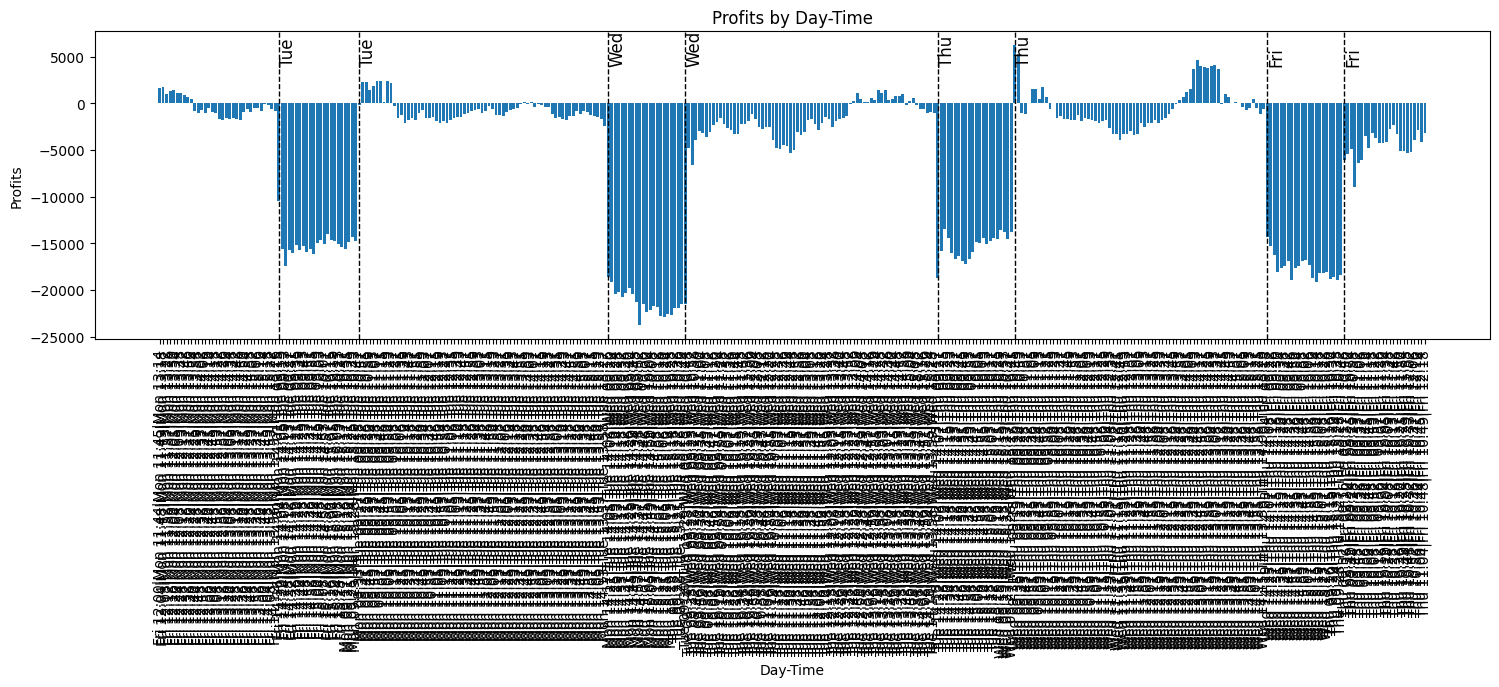

In [33]:
draw_barchart(-1, step=4, w_idx=-1, mode='val', stocks=best_stocks[:50])

In [62]:
import torch

def drop_constant_batches(data, duration):
    # Calculate the difference between each day and the previous one
    diffs = data[:, 1:] - data[:, :-1]

    # Find where prices are constant
    is_constant = diffs == 0

    # Calculate the sum of constant days in a rolling window of size `duration`
    rolling_sums = torch.nn.functional.conv1d(
        is_constant.float().unsqueeze(1),
        torch.ones(1, 1, duration, device=is_constant.device),
        padding=duration-1
    ).squeeze(1)

    # Find where the sum equals `duration`, i.e. there are `duration` constant days
    has_constant_prices = torch.any(rolling_sums >= duration, dim=-1)

    # Return data excluding batches with constant prices
    return data[~has_constant_prices]

# Example usage:
data = torch.tensor([[[1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0]]*3]*2).permute(0,2,1)
print(data.shape)
duration = 4

filtered_data = drop_constant_batches(data, duration)


torch.Size([2, 11, 3])


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [1, 1, 4], but got 4-dimensional input of size [2, 1, 10, 3] instead